In [1]:
import re
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os
import cv2
import glob
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import shutil
from decimal import Decimal, getcontext

from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
# from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
# from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

2023-05-09 17:32:02.834854: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 17:32:06.080388: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sac0380/miniconda3/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-09 17:32:06.080454: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sac0380/miniconda3/lib/python3.10/site-packages/cv2/.

In [2]:
image_size = [224, 224] + [3,]
dir = 'images/'

## Loading Data

In [4]:
data = pd.read_csv('TRY_final.txt', sep=',', encoding='latin-1')
data = data[data['mean_3110'].notna()]
data.head()

,AccSpeciesName,mean_14,mean_3117,mean_3106,mean_4,mean_3110,mean_26,stddev_14,stddev_3117,stddev_3106,stddev_4,stddev_3110,stddev_26,PlantGrowthForm
3,Abarema adenophora,24.422045,11.820481,NaN,0.663459,56861.990000,NaN,1.593152,1.030987,NaN,0.132959,NaN,NaN,tree
11,Abarema macradenia,23.394909,8.319237,31.670558,0.438332,16535.000000,90.000000,0.000000,0.129421,0.679612,0.000000,0.0,0.000000,tree
29,Abies alba,13.095739,7.846480,47.975610,0.499512,18.921429,70.544591,2.731756,2.738197,15.637276,0.076731,NaN,26.875742,tree
31,Abies balsamea,14.619919,16.226192,4.047670,0.457618,34.202755,7.473453,3.278028,6.272770,6.972198,0.093733,NaN,3.054439,tree
48,Abies fraseri,18.077778,5.566903,20.138400,NaN,22.801836,7.202712,3.111181,0.451749,5.774298,NaN,NaN,0.928773,tree


In [5]:
file = open('unique_species_names.txt', 'r')
Lines = file.readlines()
unique_species = [i.strip() for i in Lines]

In [6]:
import pickle

with open('leaf.pkl', 'rb') as fp:
    y_mean = pickle.load(fp)

## Dividing Data into Folders for Tensorflow 

In [6]:
y_dict = dict()
y_mean, y_std = [], []
for image in tqdm(glob.glob("images/*")):
    try:
        val = data.loc[data['AccSpeciesName'] == image[7:re.search(r"\d", image).start()], 'mean_3110'].values[0]
        y_mean.append(val)
        if not os.path.exists('/home/sac0380/plant_trait_identification/training/'+str(val)):
            os.mkdir('/home/sac0380/plant_trait_identification/training/'+str(val))
        shutil.copy(image, '/home/sac0380/plant_trait_identification/training/'+str(val))
        
    except:
        continue

100%|██████████| 12782/12782 [02:32<00:00, 83.96it/s]  


In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory('/home/sac0380/plant_trait_identification/segmented_images/', labels=y_mean, batch_size=32, label_mode='int', image_size=(224, 224), subset='training', validation_split = 0.2, seed=123)
validation_dataset = tf.keras.utils.image_dataset_from_directory('/home/sac0380/plant_trait_identification/segmented_images/', labels=y_mean, batch_size=32, label_mode='int', image_size=(224, 224), subset='validation', validation_split = 0.2, seed=123)

Found 11270 files belonging to 1497 classes.
Using 9016 files for training.


2023-05-09 17:32:21.624013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 17:32:21.645975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 17:32:21.646125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 17:32:21.646541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Found 11270 files belonging to 1497 classes.
Using 2254 files for validation.


## Processing Data

In [8]:
maxx = np.amax(y_mean)
minn = np.amin(y_mean)
maxx, minn

(736051.0, 2.49833333333333)

In [9]:
def norm(image, label):
    global maxx
    global minn
    label = ((2*(label - minn)) / (maxx - minn)) - 1
    print(label)
    return image, label

In [10]:
train_dataset = train_dataset.map(norm)
validation_dataset = validation_dataset.map(norm)

Tensor("sub_1:0", shape=(None,), dtype=float64)
Tensor("sub_1:0", shape=(None,), dtype=float64)


## Model

In [11]:
base_model = ResNet50V2(input_shape=[224, 224] + [3,],include_top=False, weights='imagenet')
base_model.trainable = False

In [12]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
x = BatchNormalization()(x)
#x = Dense(8, activation = 'relu')(x)
output = Dense(1, activation='tanh')(x)
model = tf.keras.Model(inputs, output)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 avg_pool (GlobalAveragePool  (None, 2048)             0         
 ing2D)                                                          
                                                             

In [14]:
model.compile(loss = 'mean_absolute_error' , optimizer = Adam(learning_rate=0.00001) , metrics = ['mse', 'mae'])

## Training and Fine-Tuning

In [15]:
history = model.fit(train_dataset, epochs=15, batch_size=32, validation_data=validation_dataset)

Epoch 1/15


2023-05-09 17:32:43.495932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8901
2023-05-09 17:32:47.746689: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f36d739d9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-09 17:32:47.746715: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2023-05-09 17:32:48.130763: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/282 [..............................] - ETA: 59:57 - loss: 0.9619 - mse: 1.3950 - mae: 0.9619

2023-05-09 17:32:49.518572: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


282/282 [==============================] - 60s 168ms/step - loss: 0.8844 - mse: 1.2385 - mae: 0.8844 - val_loss: 0.8443 - val_mse: 1.1011 - val_mae: 0.8443
Epoch 2/15
282/282 [==============================] - 20s 70ms/step - loss: 0.7770 - mse: 1.1046 - mae: 0.7770 - val_loss: 0.6965 - val_mse: 0.9528 - val_mae: 0.6965
Epoch 3/15
282/282 [==============================] - 20s 70ms/step - loss: 0.7042 - mse: 1.0202 - mae: 0.7042 - val_loss: 0.6223 - val_mse: 0.8674 - val_mae: 0.6223
Epoch 4/15
282/282 [==============================] - 20s 70ms/step - loss: 0.6413 - mse: 0.9312 - mae: 0.6413 - val_loss: 0.5634 - val_mse: 0.7826 - val_mae: 0.5634
Epoch 5/15
282/282 [==============================] - 20s 70ms/step - loss: 0.5844 - mse: 0.8332 - mae: 0.5844 - val_loss: 0.5031 - val_mse: 0.6838 - val_mae: 0.5031
Epoch 6/15
282/282 [==============================] - 20s 70ms/step - loss: 0.5163 - mse: 0.7081 - mae: 0.5163 - val_loss: 0.4419 - val_mse: 0.5783 - val_mae: 0.4419
Epoch 7/15
282

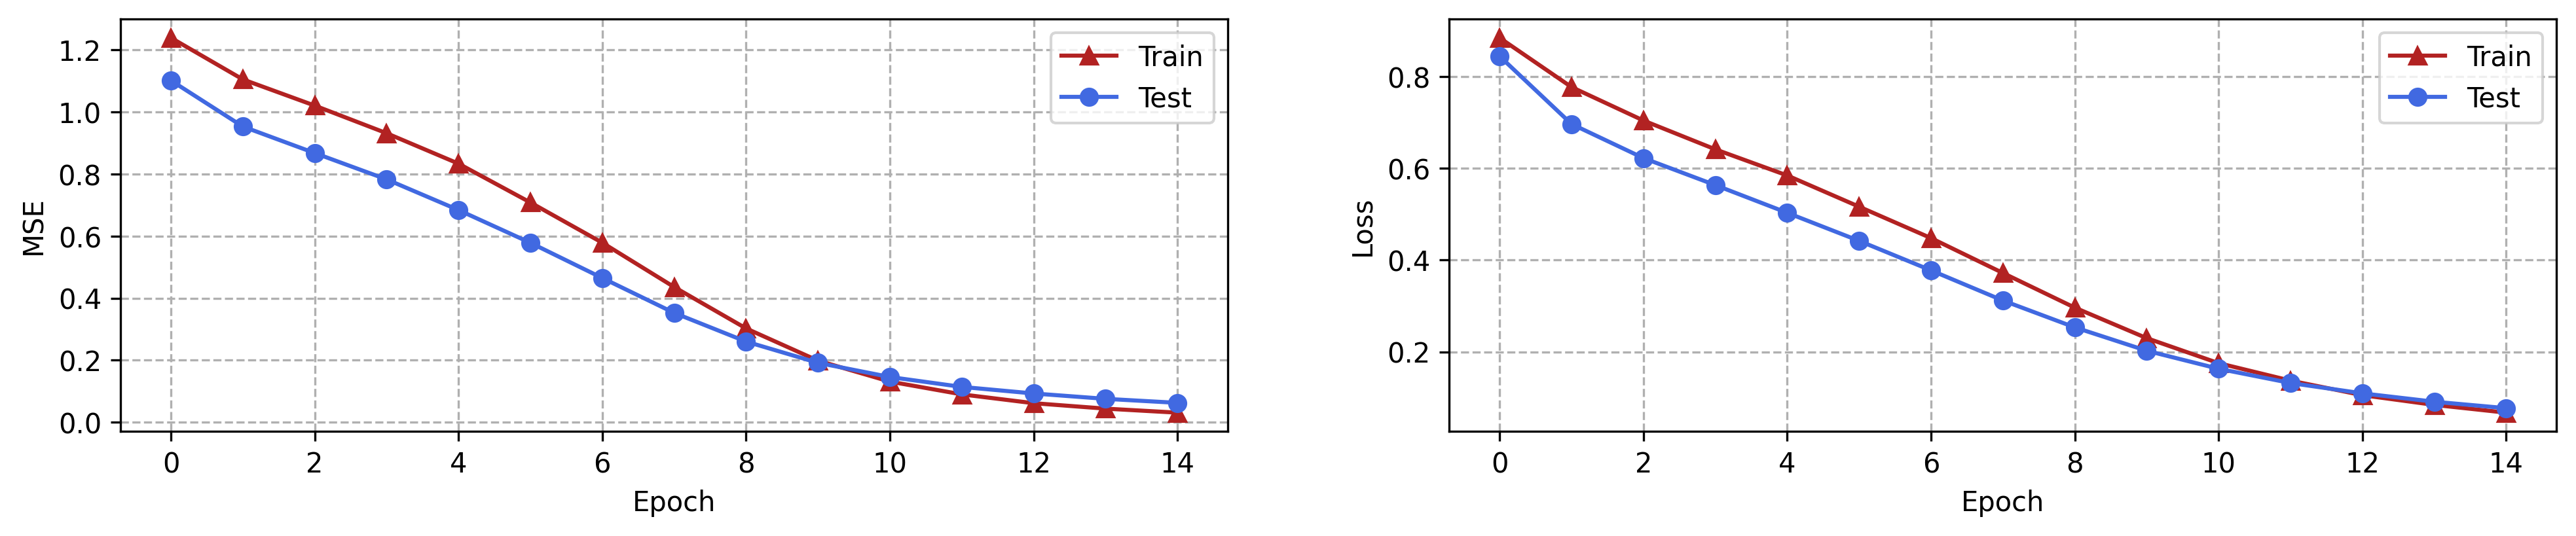

In [16]:
fig = plt.figure(figsize=(16, 6), dpi=300)

ax = fig.add_subplot(221)
ax.plot(history.history["mse"], marker="^", label = "Train", color="firebrick")
ax.plot(history.history["val_mse"], marker="o", label = "Test", color="royalblue")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax.legend()
ax.grid(True, ls="--")

ax = fig.add_subplot(222)
ax.plot(history.history["loss"], marker="^", label = "Train", color="firebrick")
ax.plot(history.history["val_loss"], marker="o", label = "Test", color="royalblue")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(True, ls="--")

# ax = fig.add_subplot(223)
# ax.plot(history.history["auc"], marker="^", label = "Train", color="firebrick")
# ax.plot(history.history["val_auc"], marker="o", label = "Test", color="royalblue")
# ax.set_xlabel("Epoch")
# ax.set_ylabel("AUC")
# ax.legend()
# ax.grid(True, ls="--")

fig.show()

In [17]:
base_model.trainable = True
model.compile(loss = 'mean_absolute_error' , optimizer = Adam(learning_rate=0.000007) , metrics = ['mse', 'mae'])
history = model.fit(train_dataset, epochs=3, batch_size=32, validation_data=validation_dataset)

Epoch 1/3


2023-05-09 17:38:26.790579: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-09 17:38:26.790610: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-09 17:38:26.807497: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-09 17:38:26.807532: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

281/282 [============================>.] - ETA: 0s - loss: 0.0391 - mse: 0.0111 - mae: 0.0391

2023-05-09 17:39:25.861169: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-09 17:39:25.861236: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-09 17:39:25.874572: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-09 17:39:25.874612: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

282/282 [==============================] - 74s 198ms/step - loss: 0.0391 - mse: 0.0112 - mae: 0.0391 - val_loss: 0.0336 - val_mse: 0.0129 - val_mae: 0.0336
Epoch 2/3
282/282 [==============================] - 55s 193ms/step - loss: 0.0200 - mse: 0.0032 - mae: 0.0200 - val_loss: 0.0207 - val_mse: 0.0076 - val_mae: 0.0207
Epoch 3/3
282/282 [==============================] - 55s 194ms/step - loss: 0.0140 - mse: 0.0023 - mae: 0.0140 - val_loss: 0.0177 - val_mse: 0.0097 - val_mae: 0.0177


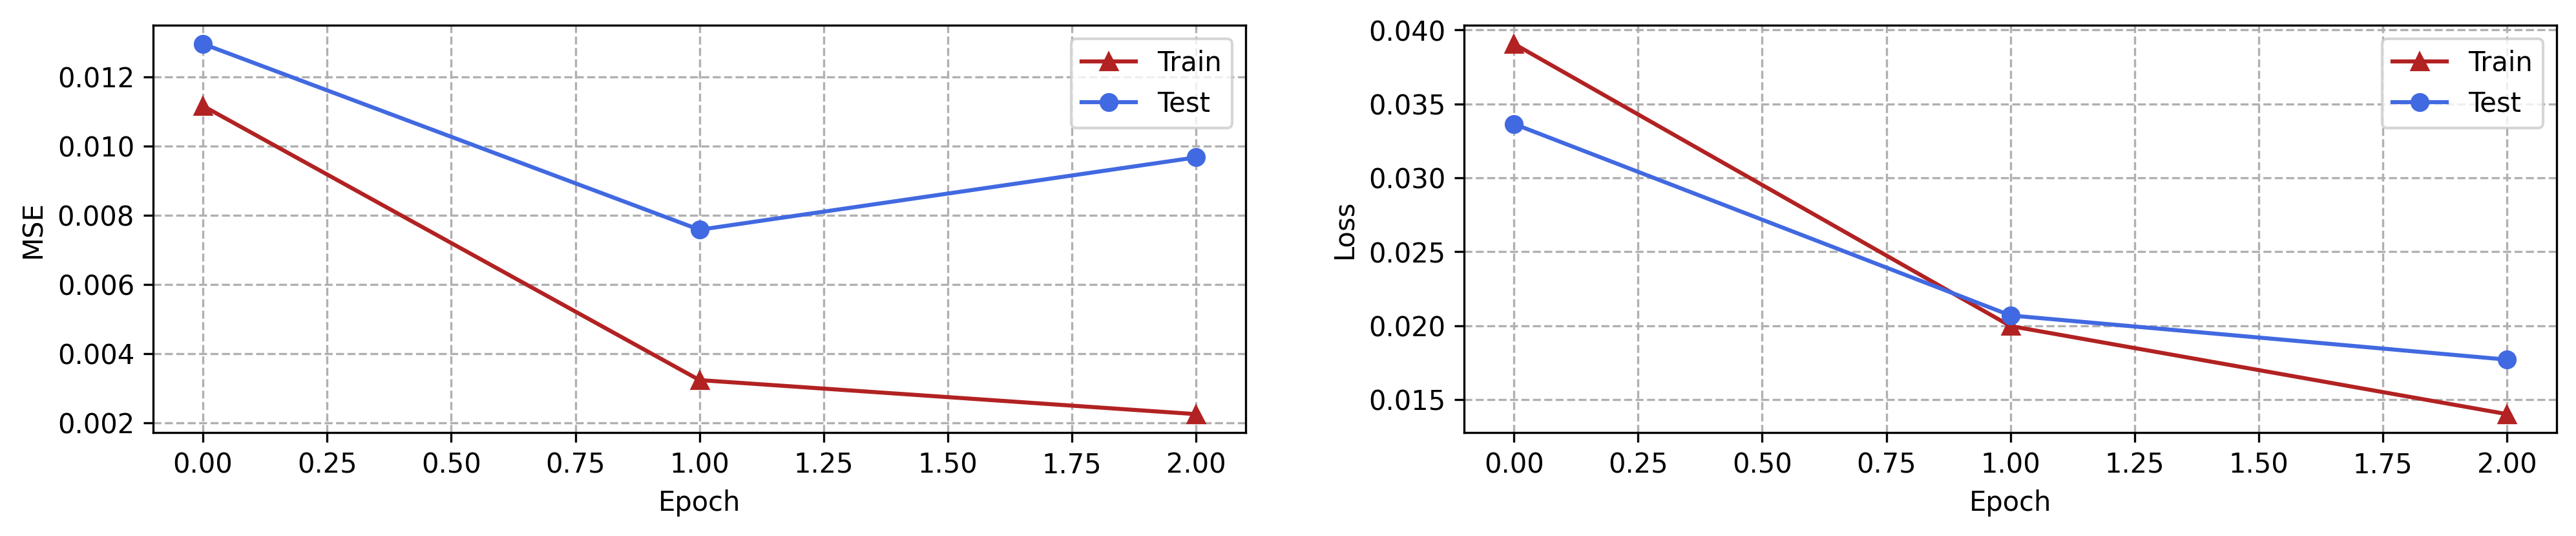

In [18]:
fig = plt.figure(figsize=(16, 6), dpi=300)

ax = fig.add_subplot(221)
ax.plot(history.history["mse"], marker="^", label = "Train", color="firebrick")
ax.plot(history.history["val_mse"], marker="o", label = "Test", color="royalblue")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax.legend()
ax.grid(True, ls="--")

ax = fig.add_subplot(222)
ax.plot(history.history["loss"], marker="^", label = "Train", color="firebrick")
ax.plot(history.history["val_loss"], marker="o", label = "Test", color="royalblue")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(True, ls="--")

# ax = fig.add_subplot(223)
# ax.plot(history.history["auc"], marker="^", label = "Train", color="firebrick")
# ax.plot(history.history["val_auc"], marker="o", label = "Test", color="royalblue")
# ax.set_xlabel("Epoch")
# ax.set_ylabel("AUC")
# ax.legend()
# ax.grid(True, ls="--")

fig.show()

## Saving Data

In [19]:
model.save("leaf_area_segmented.h5")

In [18]:
import pickle

with open('leaf.pkl', 'wb') as fp:
    pickle.dump(y_mean, fp)